Missing values in each column:
Year                                   0
Company                                0
Category                               0
Market Cap(in B USD)                   1
Revenue                                0
Gross Profit                           0
Net Income                             0
Earning Per Share                      0
EBITDA                                 0
Share Holder Equity                    0
Cash Flow from Operating               0
Cash Flow from Investing               0
Cash Flow from Financial Activities    0
Current Ratio                          0
Debt/Equity Ratio                      0
ROE                                    0
ROA                                    0
ROI                                    0
Net Profit Margin                      0
Free Cash Flow per Share               0
Return on Tangible Equity              0
Number of Employees                    0
Inflation Rate(in US)                  0
dtype: int64
Before outlie

<Figure size 1400x1000 with 0 Axes>

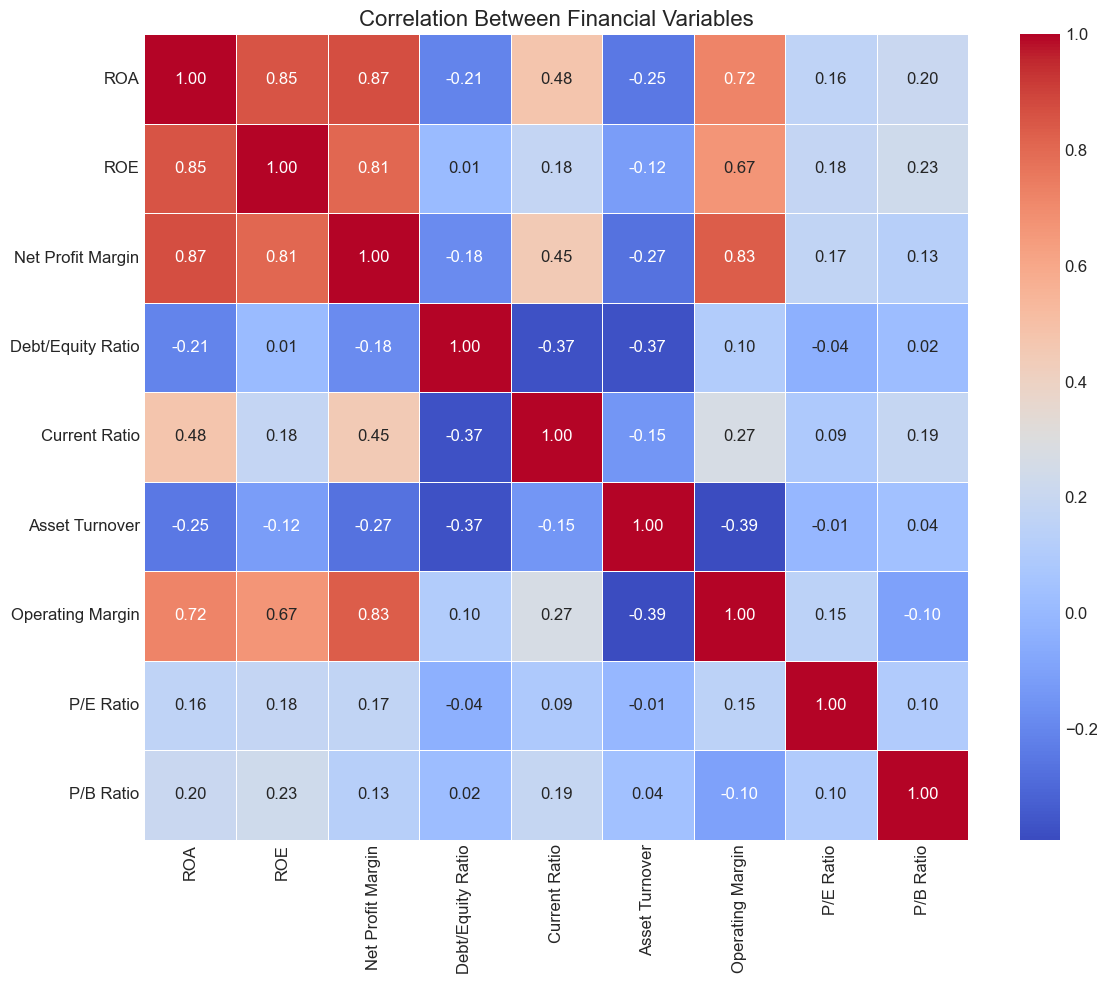

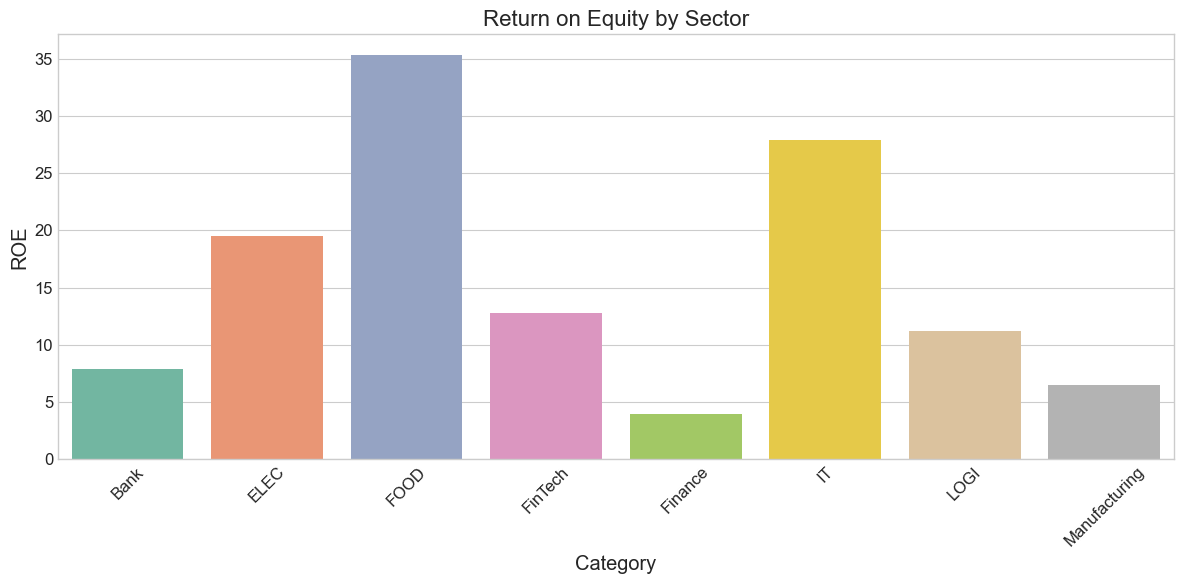

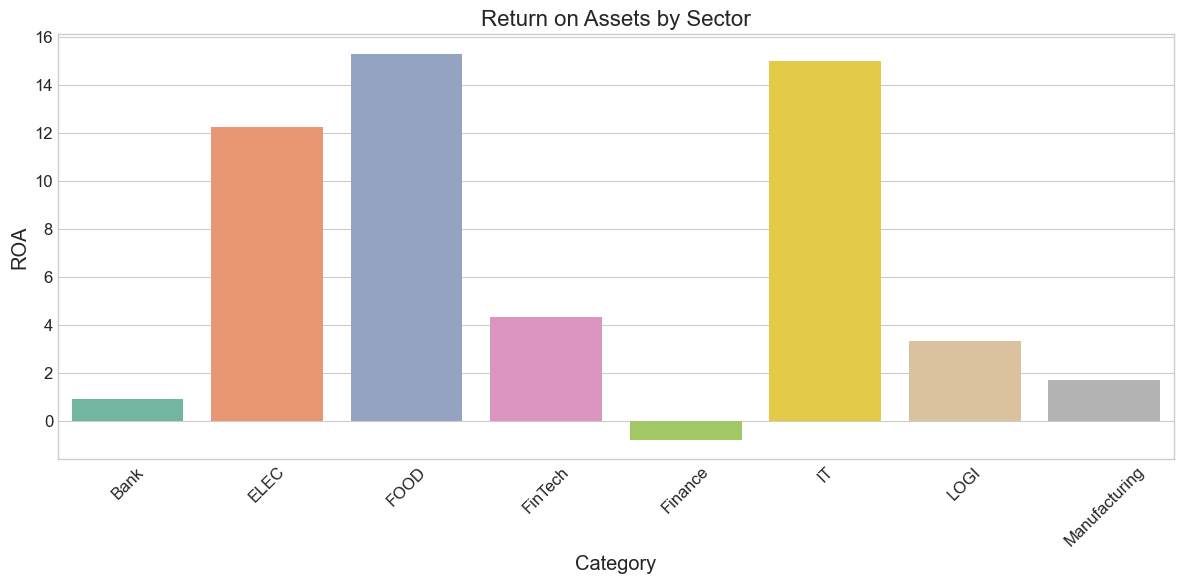

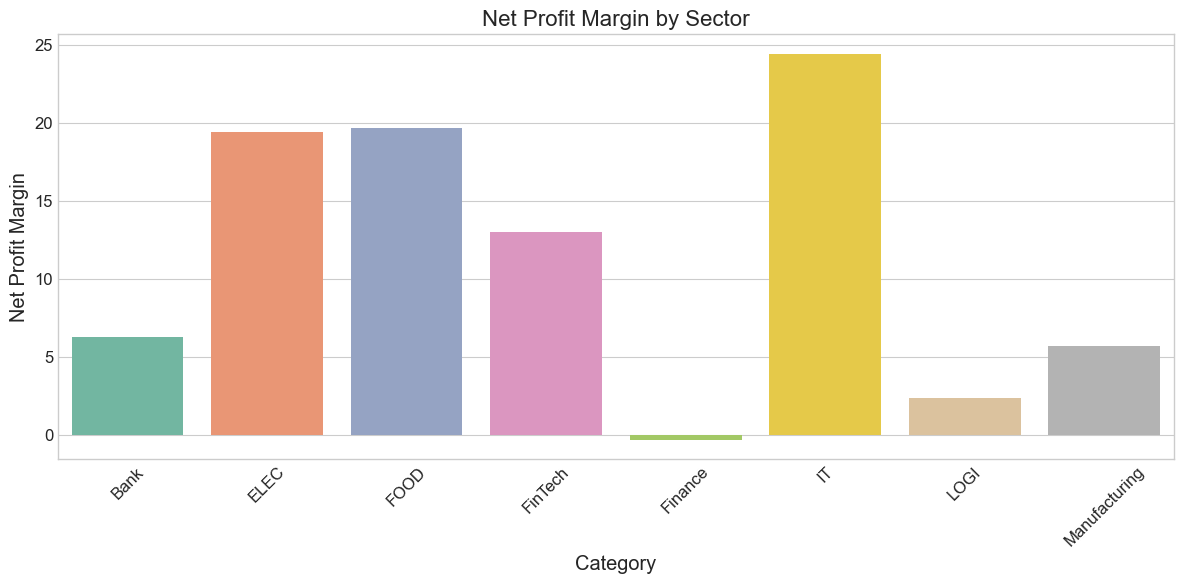

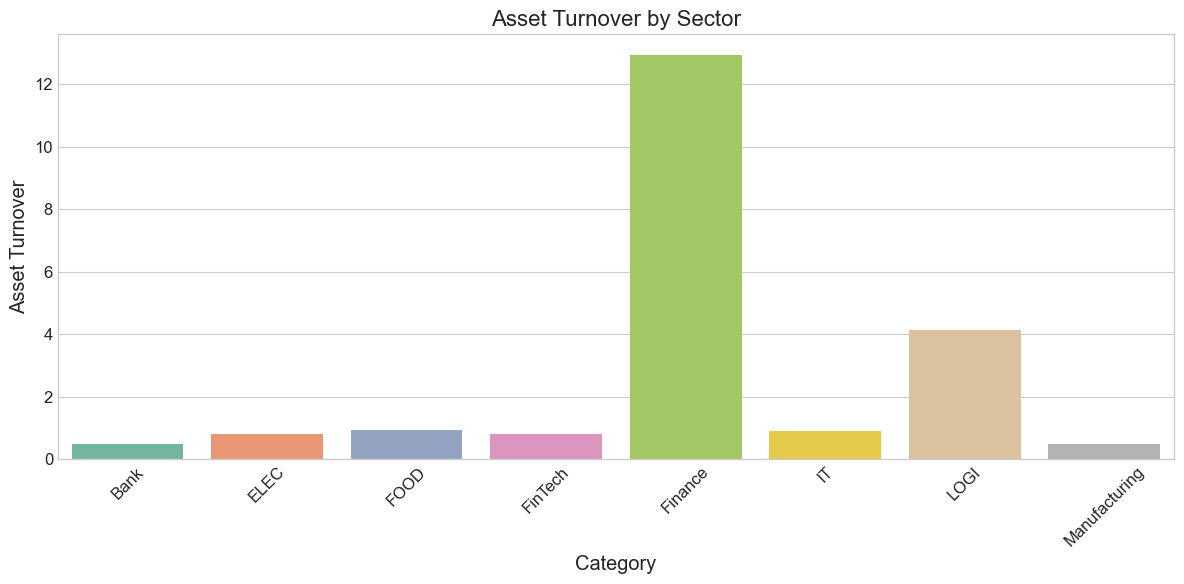

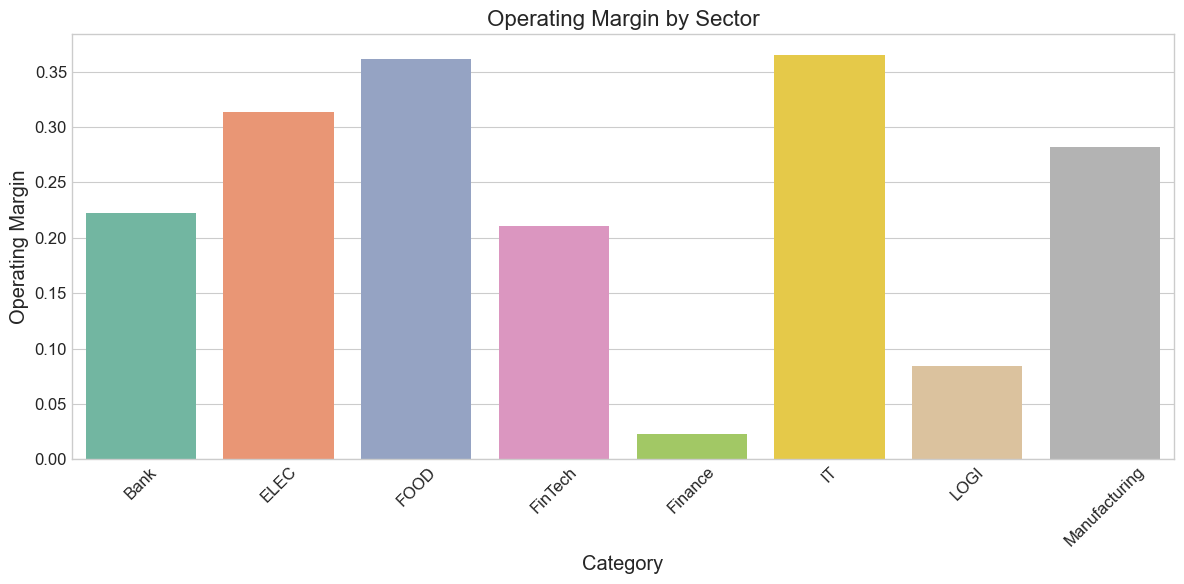

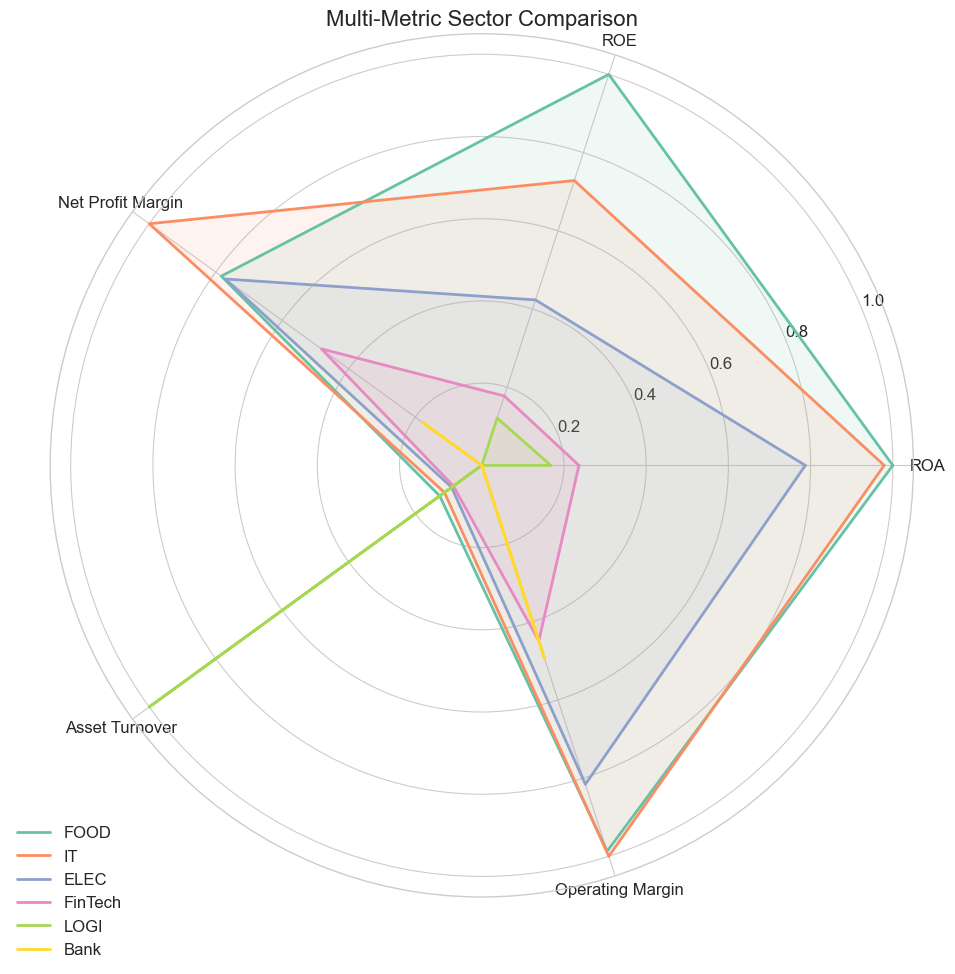

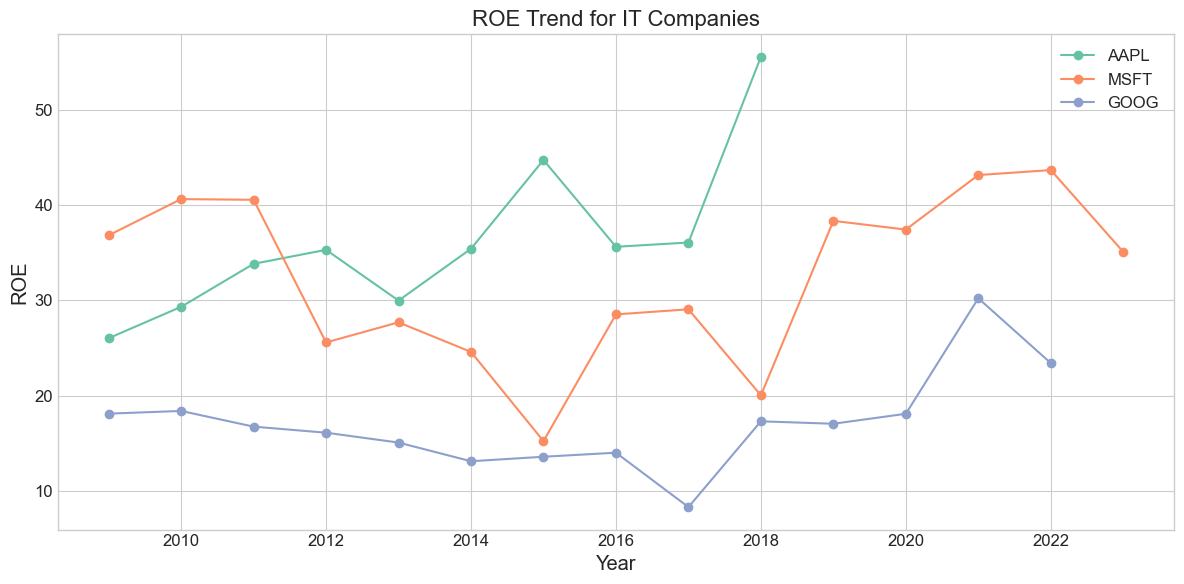

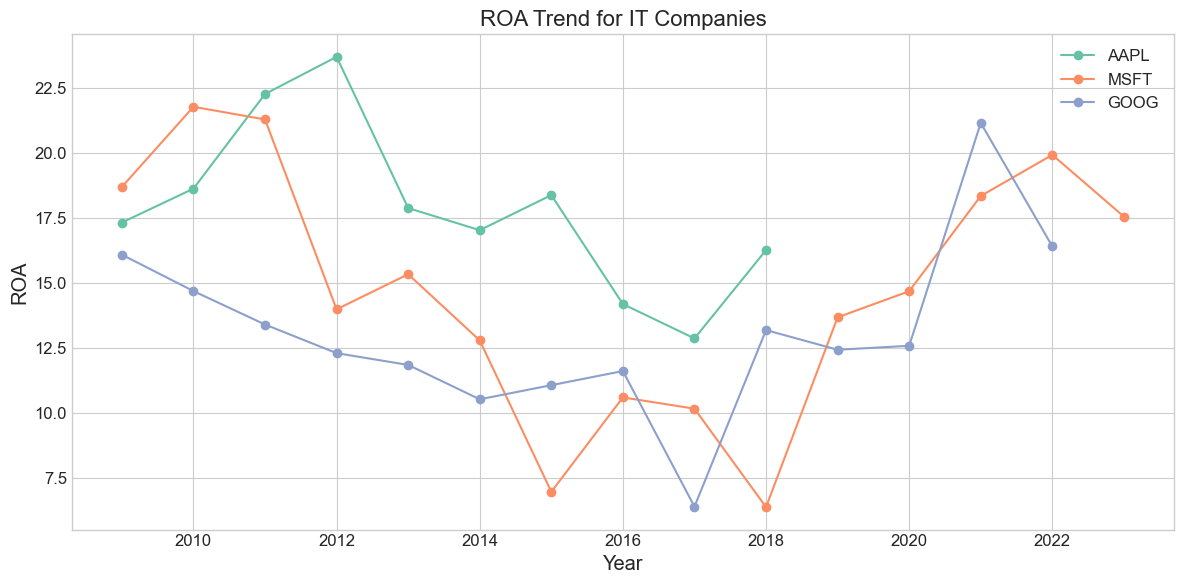

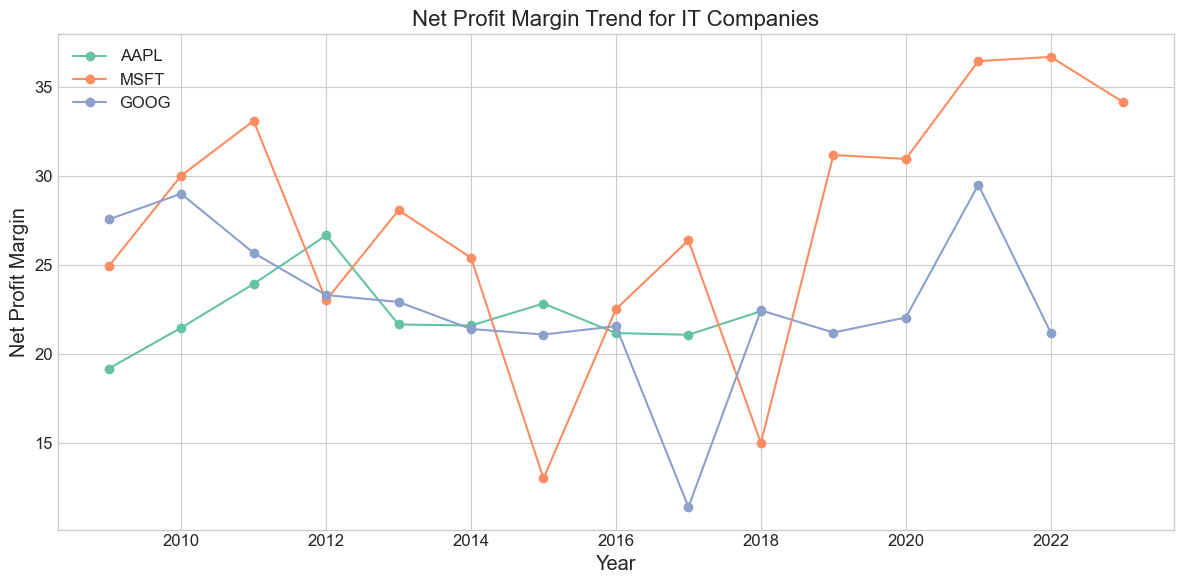


Visualization complete! Generated the following files:
1. financial_correlation_heatmap.png - Correlation between financial variables
2. Multiple sector comparison bar charts (ROE, ROA, etc.)
3. sector_radar_comparison.png - Multi-metric sector comparison
4. Time series analysis charts for IT sector companies


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the data
# Assuming the data is in a CSV file named 'Financial_Statements.csv'
df = pd.read_csv('Financial_Statements.csv')

# Data cleaning and validation steps
# 1. Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# 2. Convert columns to appropriate data types
numeric_cols = ['Revenue', 'Share Holder Equity', 'Debt/Equity Ratio', 
                'Net Income', 'EBITDA', 'ROA', 'ROE', 'Net Profit Margin', 
                'Current Ratio', 'Market Cap(in B USD)']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Handle missing values
df = df.dropna(subset=['Revenue', 'Share Holder Equity', 'Debt/Equity Ratio'], how='any')

# 4. Check for and handle extreme values/outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to key financial metrics
for col in ['Debt/Equity Ratio', 'ROE', 'ROA', 'Net Profit Margin']:
    if col in df.columns:
        print(f"Before outlier removal for {col}: {len(df)} rows")
        df = remove_outliers(df, col)
        print(f"After outlier removal for {col}: {len(df)} rows")

# Calculate missing metrics

# 1. Asset Turnover (Rotation des actifs)
# Calculate Total Assets based on Share Holder Equity and Debt/Equity Ratio
df['Total Assets'] = df['Share Holder Equity'] * (1 + df['Debt/Equity Ratio'])

# Calculate Asset Turnover (Rotation des actifs)
df['Asset Turnover'] = df['Revenue'] / df['Total Assets']

# 2. Total Debt (Dettes)
# Using Debt/Equity ratio: Debt = Share Holder Equity * Debt/Equity Ratio
df['Total Debt'] = df['Share Holder Equity'] * df['Debt/Equity Ratio']

# Additional metrics that might be useful:
# 3. Operating Margin (if needed)
df['Operating Margin'] = df['EBITDA'] / df['Revenue']

# 4. Price to Earnings (P/E) Ratio
df['P/E Ratio'] = df['Market Cap(in B USD)'] * 1000000000 / (df['Net Income'] * 1000000)  # Converting to same units

# 5. Price to Book Ratio
df['P/B Ratio'] = df['Market Cap(in B USD)'] * 1000000000 / (df['Share Holder Equity'] * 1000000)  # Converting to same units

# Save the updated dataset

print("Added metrics:")
print("- Asset Turnover (Rotation des actifs)")
print("- Total Debt (Dettes)")
print("- Operating Margin")
print("- P/E Ratio")
print("- P/B Ratio")
print("- Total Assets")

# Display the first few rows of the updated dataset with the new metrics
print("\nUpdated dataset preview:")
print(df[['Year', 'Company', 'Revenue', 'Total Assets', 'Asset Turnover', 'Total Debt', 'Operating Margin', 'P/E Ratio', 'P/B Ratio']].head())

# ------------- VISUALIZATION CODE ------------- #

# Set the style for the visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.figure(figsize=(14, 10))

# 1. Correlation heatmap between financial variables
# Select numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_metrics = ['ROA', 'ROE', 'Net Profit Margin', 'Debt/Equity Ratio', 
                       'Current Ratio', 'Asset Turnover', 'Operating Margin', 
                       'P/E Ratio', 'P/B Ratio']

# Use only columns that exist in the dataset
correlation_metrics = [col for col in correlation_metrics if col in df.columns]

plt.figure(figsize=(12, 10))
correlation_matrix = df[correlation_metrics].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Financial Variables', fontsize=16)
plt.tight_layout()
plt.savefig('financial_correlation_heatmap.png')
plt.show()


# 2. Performance comparison by sector
# Group data by sector and calculate mean values for key metrics
sector_performance = df.groupby('Category').agg({
    'ROA': 'mean',
    'ROE': 'mean', 
    'Net Profit Margin': 'mean',
    'Asset Turnover': 'mean',
    'Operating Margin': 'mean',
    'Current Ratio': 'mean',
    'Debt/Equity Ratio': 'mean'
}).reset_index()

# Function to create bar plots for sector comparison
def plot_sector_comparison(metric, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Category', y=metric, data=sector_performance)
    plt.title(f'{title} by Sector', fontsize=16)
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(f'sector_comparison_{metric.replace("/", "_")}.png')
    plt.show()


# Create comparison plots for different metrics
plot_sector_comparison('ROE', 'Return on Equity')
plot_sector_comparison('ROA', 'Return on Assets')
plot_sector_comparison('Net Profit Margin', 'Net Profit Margin')
plot_sector_comparison('Asset Turnover', 'Asset Turnover')
plot_sector_comparison('Operating Margin', 'Operating Margin')

# 3. Multi-metric sector comparison (radar chart)
# Select top sectors for clarity
if len(sector_performance) > 6:
    top_sectors = sector_performance.nlargest(6, 'ROE')
else:
    top_sectors = sector_performance

# Prepare data for radar chart
metrics = ['ROA', 'ROE', 'Net Profit Margin', 'Asset Turnover', 'Operating Margin']
metrics = [m for m in metrics if m in sector_performance.columns]

# Normalize the data for radar chart
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
radar_data = top_sectors[metrics].copy()
radar_data[metrics] = scaler.fit_transform(radar_data[metrics])

# Create radar chart
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Set the angles for each metric
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Plot each sector
for i, sector in enumerate(top_sectors['Category']):
    values = radar_data.loc[radar_data.index[i], metrics].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, label=sector)
    ax.fill(angles, values, alpha=0.1)

# Set labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title('Multi-Metric Sector Comparison', size=16)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.savefig('sector_radar_comparison.png')
plt.show()


# 4. Time series analysis for selected companies in IT sector
it_companies = df[df['Category'] == 'IT'].copy()
if not it_companies.empty:
    for metric in ['ROE', 'ROA', 'Net Profit Margin']:
        plt.figure(figsize=(12, 6))
        for company in it_companies['Company'].unique():
            company_data = it_companies[it_companies['Company'] == company]
            plt.plot(company_data['Year'], company_data[metric], marker='o', label=company)
        
        plt.title(f'{metric} Trend for IT Companies', fontsize=16)
        plt.xlabel('Year')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'it_sector_{metric}_trend.png')
        plt.show()


print("\nVisualization complete! Generated the following files:")
print("1. financial_correlation_heatmap.png - Correlation between financial variables")
print("2. Multiple sector comparison bar charts (ROE, ROA, etc.)")
print("3. sector_radar_comparison.png - Multi-metric sector comparison")
print("4. Time series analysis charts for IT sector companies")
df.to_csv("cleaned_data.csv")

In [30]:
# Clustering Phase
# Add necessary imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Select relevant features for clustering
clustering_features = [
    'ROA', 'ROE', 'Net Profit Margin', 'Debt/Equity Ratio',
    'Current Ratio', 'Asset Turnover', 'Operating Margin',
    'P/E Ratio', 'P/B Ratio'
]

# Check for missing values in clustering features
print("Missing values in clustering features:")
print(df[clustering_features].isnull().sum())

# Impute missing values with the mean (if any)
df_clustering = df[clustering_features].fillna(df[clustering_features].mean())

# Scale features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering)

# Determine optimal K using Elbow Method
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.savefig('elbow_method.png')
plt.close()

# Silhouette Score for K evaluation
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.savefig('silhouette_score.png')
plt.close()

# Choose optimal K (example: K=3 based on plots)
optimal_k = 3

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Analyze clusters
cluster_summary = df.groupby('Cluster')[clustering_features].mean().T
print("\nCluster Summary (Mean Values):")
print(cluster_summary)

# PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=df,
    palette='viridis', s=100, alpha=0.8
)
plt.title('Clusters Visualized with PCA')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.savefig('clusters_pca.png')
plt.close()

# Box plots for cluster analysis
plt.figure(figsize=(15, 10))
for i, feature in enumerate(clustering_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.savefig('cluster_box_plots.png')
plt.close()

# Update sector comparison with cluster info
plt.figure(figsize=(14, 7))
sns.barplot(x='Category', y='ROE', hue='Cluster', data=df, ci=None)
plt.title('ROE by Sector and Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sector_cluster_roe.png')
plt.close()

# Save dataset with cluster labels
df.to_csv('clustered_data.csv', index=False)

print("\nClustering complete! Generated files:")
print("1. elbow_method.png")
print("2. silhouette_score.png")
print("3. clusters_pca.png")
print("4. cluster_box_plots.png")
print("5. sector_cluster_roe.png")
print("6. clustered_data.csv")

Missing values in clustering features:
ROA                  0
ROE                  0
Net Profit Margin    0
Debt/Equity Ratio    0
Current Ratio        0
Asset Turnover       0
Operating Margin     0
P/E Ratio            1
P/B Ratio            1
dtype: int64

Cluster Summary (Mean Values):
Cluster                    0           1          2
ROA                15.306513    2.859422  -5.274000
ROE                27.878228    8.901003  10.287400
Net Profit Margin  24.129505    6.442722  -2.293100
Debt/Equity Ratio   0.342902    0.482808  -1.109900
Current Ratio       3.068025    1.493275   0.775600
Asset Turnover      0.871994    1.635878  40.820446
Operating Margin    0.368055    0.183540  -0.003113
P/E Ratio          28.502789 -120.152879  -0.104439
P/B Ratio           7.519859    5.673721  -0.010744

Clustering complete! Generated files:
1. elbow_method.png
2. silhouette_score.png
3. clusters_pca.png
4. cluster_box_plots.png
5. sector_cluster_roe.png
6. clustered_data.csv


In [31]:
# New: Handle remaining missing values with iterative imputation (better for financial data)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=10, random_state=42)
df_clustering = pd.DataFrame(imputer.fit_transform(df[clustering_features]), columns=clustering_features)

# New: Robust scaling (less sensitive to outliers than StandardScaler)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(df_clustering)

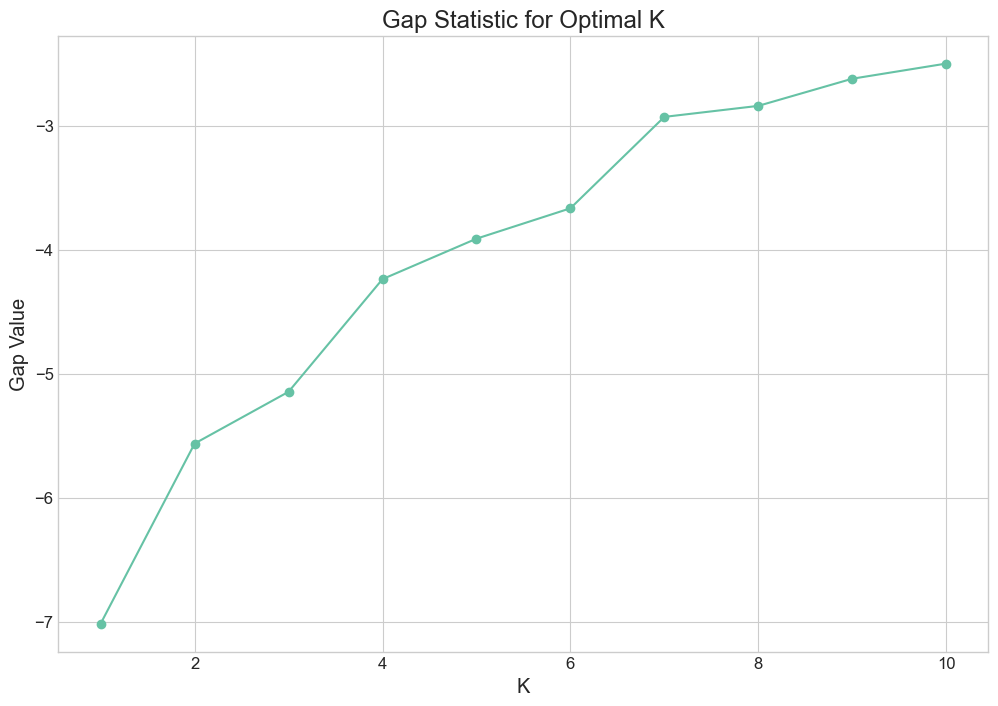

In [32]:
# New: Gap Statistic for optimal K (compares with null reference distribution)
def optimal_k_gap(scaled_data, n_refs=3, max_clusters=10):
    gaps = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(scaled_data)
        # Calculate dispersion for real data
        disp = kmeans.inertia_
        # Calculate dispersion for reference datasets
        ref_disps = []
        for _ in range(n_refs):
            random_data = np.random.random_sample(size=scaled_data.shape)
            kmeans_ref = KMeans(n_clusters=k)
            kmeans_ref.fit(random_data)
            ref_disps.append(kmeans_ref.inertia_)
        # Compute gap statistic
        gap = np.mean(np.log(ref_disps)) - np.log(disp)
        gaps.append(gap)
    return gaps

gaps = optimal_k_gap(scaled_features)
plt.plot(range(1, 11), gaps, marker='o')
plt.title('Gap Statistic for Optimal K')
plt.xlabel('K')
plt.ylabel('Gap Value')
plt.savefig('gap_statistic.png')
plt.show()


In [33]:
# New: Calculate financial health scores per cluster
df['Liquidity_Score'] = (df['Current Ratio'] - df['Current Ratio'].mean()) / df['Current Ratio'].std()
df['Profitability_Score'] = (df['ROE'] - df['ROE'].mean()) / df['ROE'].std()
df['Leverage_Score'] = (-df['Debt/Equity Ratio'] - (-df['Debt/Equity Ratio'].mean())) / df['Debt/Equity Ratio'].std()

cluster_health = df.groupby('Cluster')[['Liquidity_Score', 'Profitability_Score', 'Leverage_Score']].mean()
print("\nCluster Financial Health Scores:")
print(cluster_health)


Cluster Financial Health Scores:
         Liquidity_Score  Profitability_Score  Leverage_Score
Cluster                                                      
0               0.427890             0.693417        0.145491
1              -0.449750            -0.741391       -0.225598
2              -0.849724            -0.636570        3.998901


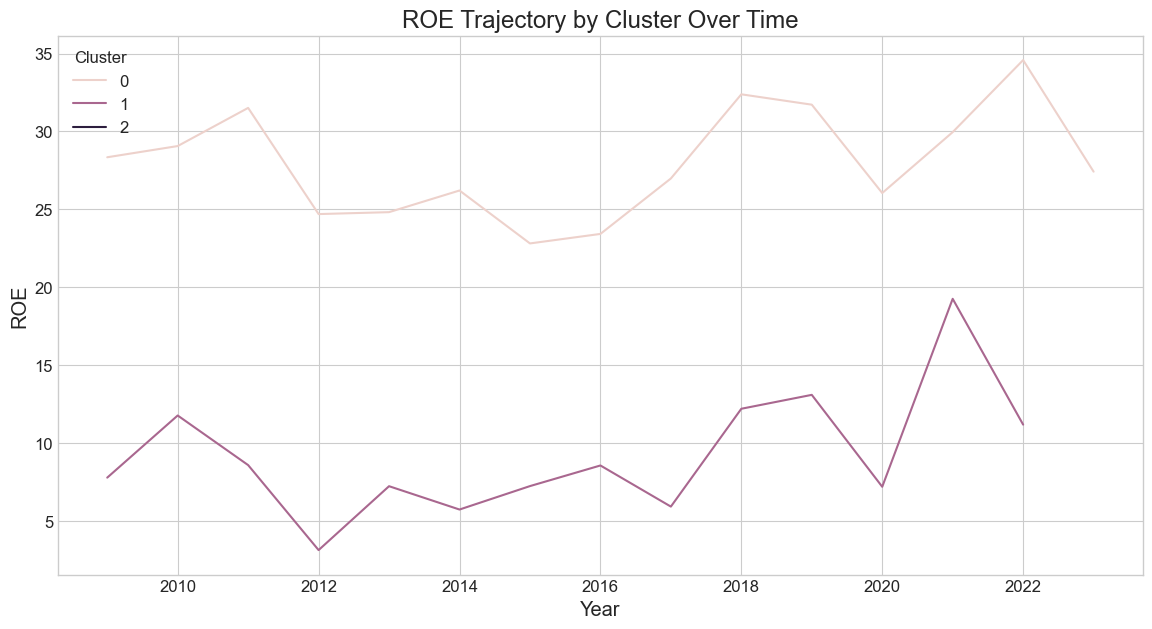

In [34]:
# New: Analyze cluster stability over time (if Year is present)
if 'Year' in df.columns:
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='Year', y='ROE', hue='Cluster', data=df, ci=None)
    plt.title('ROE Trajectory by Cluster Over Time')
    plt.savefig('cluster_roe_trends.png')
    plt.show()


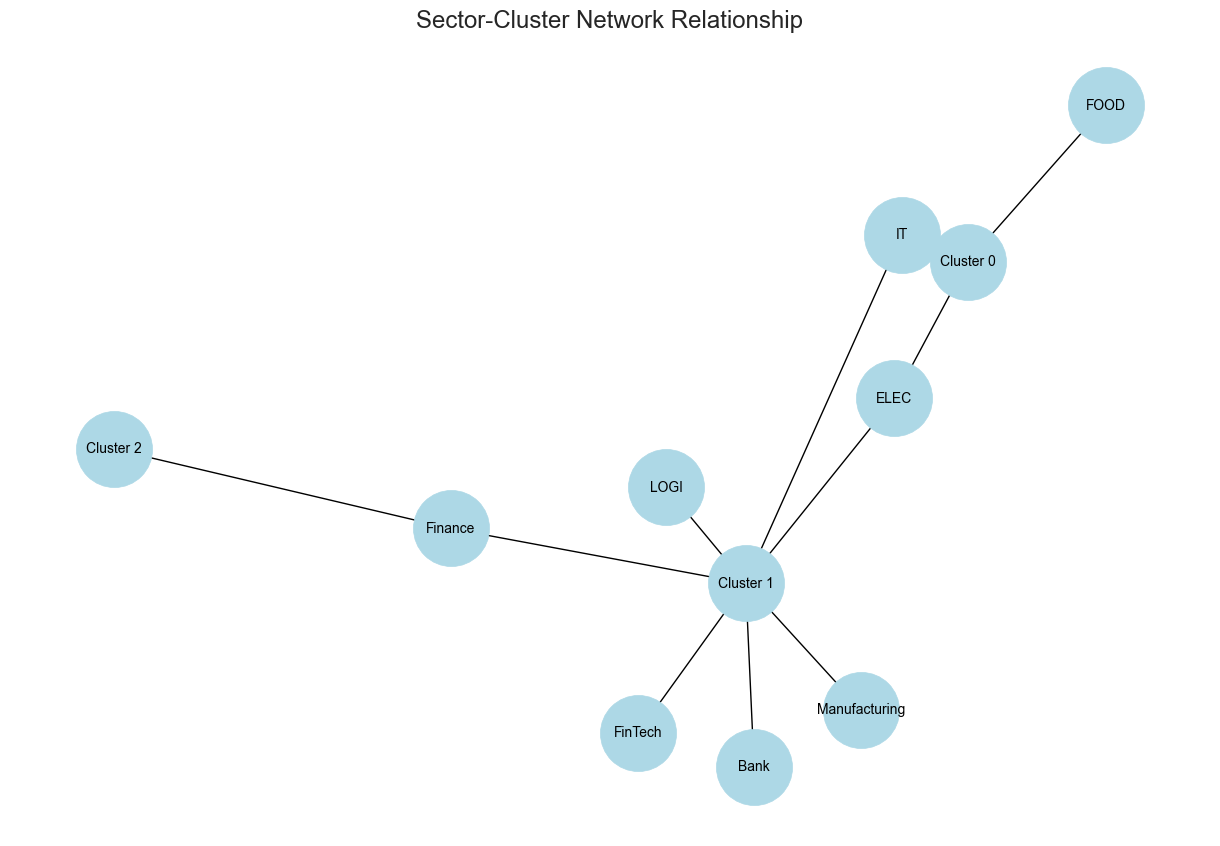

In [35]:
# New: Visualize inter-cluster relationships
import networkx as nx

G = nx.Graph()
clusters = df['Cluster'].unique()
for cluster in clusters:
    G.add_node(f'Cluster {cluster}')

# Connect clusters based on sector overlap
sector_cluster_matrix = pd.crosstab(df['Category'], df['Cluster'])
for i in sector_cluster_matrix.index:
    for j in sector_cluster_matrix.columns:
        if sector_cluster_matrix.loc[i, j] > 0:
            G.add_edge(i, f'Cluster {j}', weight=sector_cluster_matrix.loc[i, j])

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.title('Sector-Cluster Network Relationship')
plt.savefig('sector_cluster_network.png')
plt.show()